In [34]:
import numpy as np
import scipy.constants as const
from functools import reduce
import matplotlib.pyplot as plt

In [35]:
# définition de toutes les constantes utiles 
pi = const.pi
R=10
N=1000
E = 1e-19
h = const.h
hbar = const.hbar
M = const.proton_mass
alpha = 1
beta = 1
nu = E / h
omega = 2*pi*nu

Soit H l’Hamiltonien d’un oscillateur anharmonique


$H = −\frac{\hbar^2}{2M} \frac{d^2}{dx^2}+ V (x)$ $(4.6)$ 


où le potentiel anharmonique s’écrit 


$V(x) = \frac{1}{2} M \omega^2x^2 + \alpha x^3 + \beta x^4$. $(4.7)$ 


Au lieu de solutionner un système aux valeurs propres sur une base de
fonctions, on discrétisera l’espace sur une grille unidimensionnelle formée
de $N$ points ${x_j}$ telle que 


$x_1 = −R$ 

$x_2 = −R + h$ 

$... = ...$ 

$x_j = −R + (j − 1)h$ $(4.8)$ 

$... = ...$ 

$x_N = −R + (N − 1)h = +R$ 


avec $h = \frac{2x}{(N − 1)}$ et $R$ choisi suffisamment grand pour que $\psi_n(±R) \simeq 0$ où $H\psi_n(x) = E_n \psi_n(x)$.

On commence par discrétisé l'opérateur différentielle sur la grille unidimensionelle.

$\frac{d^2f_i}{dx^2} \simeq \frac{f_{i-1}-2f_i + f_{i+1}}{(\Delta x)^2} = \frac{f_{i-1}-2f_i + f_{i+1}}{h^2}$ 

On peut adapter l'équation ci-dessus pour l'ensemble de l'espace discrétisé en utilisant la matrice suivante :

$\begin{pmatrix}
-2 & 1 & 0 & 0 & \dot \\
1 & -2 & 1 & \dot & 0 \\
0 & 1 & \dot & 1 & 1 \\
0 & \dot & 1 & -2 & 1 \\
\dot & 0 & 1 & 1 & -2 \\
\end{pmatrix}$



**Définition des fonctions**

In [36]:
def discrétise_espace(R, N):
    return list(-R + (i-1) * (2*R)/(N-1) for i in range(1, N+1))

In [37]:
def differentielle_discretiser(N):
    D = np.zeros((N, N))
    D[0, 0] = 2
    D[N-1, N-1] = 2
    D[0, 1] = -1
    D[N-1, N-2] = -1

    for i in range(1, N-1):
        D[i, i-1] = -1
        D[i, i+1] = -1
        D[i, i] = 2
        
    return D

In [38]:
def x_carré(R, N):
    return np.array([element**2 for element in discrétise_espace(R, N)])

def x_cube(R, N): 
    return np.array([element**3 for element in discrétise_espace(R, N)])

def x_quatre(R, N): 
    return np.array([element**4 for element in discrétise_espace(R, N)])

In [39]:
# calcul le potentielle (en matrine 1 x N)

def V(R, N, alpha, beta, M, omega): 
    return (1/2)*M*x_carré(R, N)*omega**2 + alpha*x_cube(R, N) + beta*x_quatre(R, N)

In [40]:
# calcul la matrice N x N de l'hamiltonien 

def H(R, N, alpha, beta, M, omega): 
    return (hbar**2/(2*M))*differentielle_discretiser(N)/ (((2*R)/(N-1))**2) + np.diag(V(R, N, alpha, beta, M, omega))

In [41]:
# détermine la matrice orthogonale Q associé à la matrice A

def calcul_Q(A):
    k = len(A)
    Q = np.zeros((k, k))

    for i in range(0, k):
        Q[:, i] = A[:,i]

        for j in range(1, i+1):
            Q[:, i] -= (A[:, i] @ Q[:, j-1]) * Q[:, j-1]

        Q[:, i] = Q[:, i] / np.linalg.norm(Q[:, i]) 

    return Q

In [42]:
#  détermine la matrice triangulaire supérieur R

def methode_QR(A):
    Q = calcul_Q(A)
    return Q, np.transpose(Q) @ A

In [43]:
# calcul les valeurs et les vecteurs propres de la matrice A

def valeur_vecteur_propre_QR(A, epsilon):
    Q, R = methode_QR(A)
    A = np.transpose(Q) @ A @ Q
    V = Q

    def reducteur(a, b):
        if abs(a) < epsilon and abs(b) < epsilon:
            return False
        
        return True

    while reduce(reducteur, list(A[i, j] for i in range(len(A)) for j in range(len(A)) if i != j)): # si tout les élément non diagaunaux sont inférieur à epsilon la boucle s'arréte
        Q, R = methode_QR(A)
        A = np.transpose(Q) @ A @ Q
        V = V @ Q

    return A, V

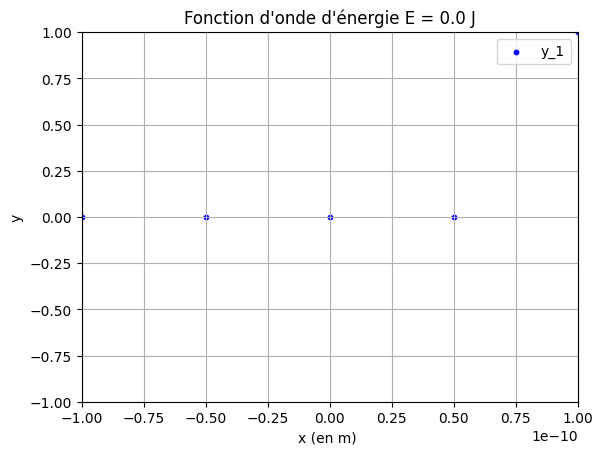

[[ 7.52261879e-18 -3.32801264e-22  7.26045345e-38  3.62345919e-38
   2.85871941e-41]
 [-3.32801264e-22  1.88264996e-18 -2.09972194e-24 -3.98828132e-35
  -3.14227061e-38]
 [ 7.25180749e-38 -2.09972194e-24  3.79933542e-19 -7.52953555e-19
   2.94906486e-38]
 [ 3.62690908e-38 -3.98756302e-35 -7.52953555e-19  1.50538006e-18
  -5.94323625e-21]
 [ 2.85448504e-41 -3.14506177e-38  6.37777596e-38 -5.94323625e-21
   7.52261286e-18]]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.90049216e-04
  9.99999688e-01]
-7.529535546501543e-19
5.0000000000000005e-20


In [44]:
# définition des constantes
R = 1e-10
N = 5
alpha = 0 
beta = 0
x = discrétise_espace(R, N)
A, V = valeur_vecteur_propre_QR(H(R, N, alpha, beta, M, omega), 10**-16)

# affichage du graphique

plt.scatter(x, V[:][4]/np.linalg.norm(V[:][4]), color='b', label='y_1', s=10)
plt.xlabel('x (en m) ')
plt.ylabel('y')
plt.axis([-1e-10, 1e-10, -1, 1])
plt.title(f'Fonction d\'onde d\'énergie E = {A[0][0]:0.1f} J')
plt.legend()
plt.grid(True)
plt.show()
print(A)
print(V[:][4])
print(np.amin(A))
print(hbar*omega/2)